In [1]:
# Import all the things and setup

import sys # for automation and parallelization
manual, scenario = (True, 'base') if 'ipykernel' in sys.argv[0] else (False, sys.argv[1])
if manual:
    %matplotlib inline

import pandas as pd
import geopandas as gpd
import shapely
from shapely.ops import unary_union
from shapely.geometry import Point, LineString, MultiPolygon, Polygon
from quetzal.model import stepmodel
import matplotlib.pyplot as plt
import numpy as np
import time
import geopy.distance

# import helper functions 
# imports all helper functions stored in class "helpers" 
%run -i helperFunctions.py

input_path = './../../input/'
output_path = './../../output/'
model_path = './../../model/'

/home/anja/anaconda3/envs/quetzal_env/lib/python3.8/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.10.3-CAPI-1.16.1). Conversions between both will be slow.
  warnings.warn(


SQLalchemy is not installed. No support for SQL output.


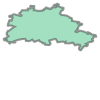

In [2]:
zones = gpd.read_file(input_path + "zones/Berliner_Ortsteile.shp")
zones = zones.to_crs(epsg=4326)
#hull = geometry.MultiPolygon(zones['geometry'].values).buffer(1e-3)
hull = unary_union([x.buffer(1e-3) for x in zones['geometry']])
hull

# get blocks centroids for points

In [3]:
# Add building block shapefile
blocks = gpd.read_file(input_path + "zones/Einwohnerdichte_2020.shp")
blocks.to_crs(epsg=4326, inplace=True)
# remove blocks without geometry property
print("removing", sum(blocks.geometry == None), 
      "blocks with",
      round(sum(blocks[blocks.geometry == None]["ew2020"])),
      "inhabitants due to lack of geometry, e.g. block with schl5 =",
     blocks[blocks.geometry == None].iloc[0]["schl5"])
blocks = blocks[blocks.geometry != None]
blocks["zone"] = None

blocks['centroids'] = blocks.centroid

removing 127 blocks with 4863 inhabitants due to lack of geometry, e.g. block with schl5 = None


In [4]:
# Funktions

In [5]:
def get_start_points_clusters_random(n, hull):  # do we need the hull here?
    points = []
    minx, miny, maxx, maxy = hull.bounds
    while len(points) < n:
        pnt = Point(np.random.uniform(minx, maxx), np.random.uniform(miny, maxy))
        if hull.contains(pnt):
            points.append(pnt)
    return points

In [6]:
def get_start_points_clusters_grid(n_x, hull):
    n_y = n_x
    x_min, y_min, x_max, y_max = hull.bounds
    x_step = (x_max-x_min)/n_x
    y_step = (y_max-y_min)/n_y
    #bounds
    grid = [item for sublist in [[Point(x_min+x_step*(i_x+i_y%2/2), y_min+i_y*y_step, ) for i_y in range(n_y+1)] for i_x in range(n_x+1)] for item in sublist]
    grid = gpd.GeoSeries(grid, crs=4326)
    grid = grid[grid.within(hull)]
    grid.index = range(len(grid))
    return [x for x in grid]

In [18]:
def k_means(n, blocks, epsilon): # epsilon: convergenzbedingung: Änderung der location der cluster < epsilon
    clusters_centroids = get_start_points_clusters_random(n,hull) # get some starting points inside hulls bounds
    #n = len(clusters_centroids)
    print(n)
    #clusters = [[] for x in range(n)] # list that later contains clusters -> list of blocks
    clusters = [[] for x in range(n)]
    
    print("n: ", n)
    changed_centers = [True]*n #initialize with true so loop starts
    
    iteration = 0
    while any(changed_centers):
        iteration += 1
        print(iteration)
        
        clusters = [[] for x in range(n)]
        changed_centers = [False]*n
        
        # add each block to a cluster
        for i,b in zip(blocks.index, blocks['centroids']):
            #print(iteration, ": block to cluster ", i)
            closest_c = clusters_centroids[0]
            min_distance = b.distance(closest_c)
            # for each block get clostest cluster_centroid
            for c in clusters_centroids:
                if b.distance(c) < min_distance:
                    distance = b.distance(c)
                    closest_c = c
            # add block to cluster
            clusters[clusters_centroids.index(closest_c)].append(i)
        
        changed = 0
        # calculate new centers for each cluster
        for c in clusters:
            #print(iteration, ": new cluster centers ", clusters.index(c))
            number_points = len(c)
            if number_points == 0: number_points=1
            x = 0
            y = 0
            for pi in c: # point index in cluster
                x += blocks['centroids'][pi].x
                y += blocks['centroids'][pi].y
            x /= number_points
            y /= number_points
            dist = geopy.distance.geodesic((x,y),(clusters_centroids[clusters.index(c)].x,clusters_centroids[clusters.index(c)].y)).meters
            
            if dist > epsilon:
                print(dist)
                changed += 1
                changed_centers[clusters.index(c)] = True
            clusters_centroids[clusters.index(c)] = shapely.geometry.Point(x,y)
        print("changed:", changed)    
    return clusters

In [20]:
array = k_means(3, blocks, 600) # n is number of points in grid

3
n:  3
1
6449.8199311830385
16489.53177160823
10477.762434367394
changed: 3
2
3390.5308910281415
4020.050678733889
1537.8842664942995
changed: 3
3
2097.9136851809812
3156.3398229984273
1770.8923615255362
changed: 3
4
1969.920781006199
2626.305336603378
1205.8746282759234
changed: 3
5
2065.6443412373756
2044.6263423718137
862.1426222584283
changed: 3
6
1506.9999872087408
1383.5664723174768
685.440356088419
changed: 3
7
981.0407890035374
893.6649238199002
changed: 2
8
761.470894005963
673.797483329596
changed: 2
9
changed: 0


In [21]:
blocks['zone'] = [item for sublist in [[n for n, arr in enumerate(array) if i in arr] for i in blocks.index] for item in sublist]

<AxesSubplot:>

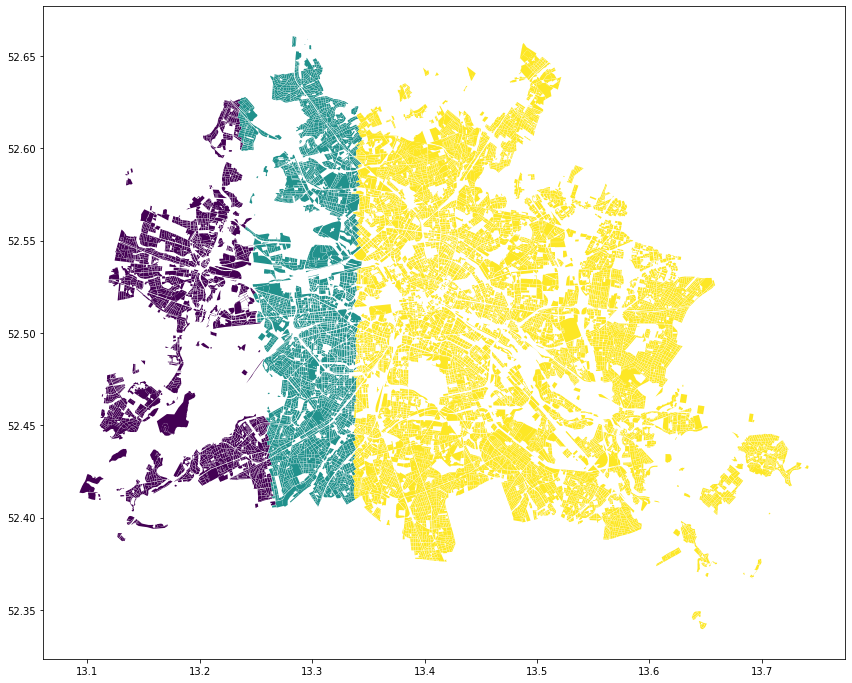

In [22]:
fig, ax = plt.subplots(figsize = (16,12))
blocks.plot(ax=ax, column='zone', cmap='viridis')

#for cluster in array:
#    blocks[blocks.index.isin(array[array.index(cluster)])].plot(ax=ax, ,cmap= "viridis")